In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
import math

# Question 2

### (g) plot n: 1 to 100 000

In [2]:
def p(n):
    """Probability of observation in bootstrap sample"""
    return 1 - (1 - 1/n)**n

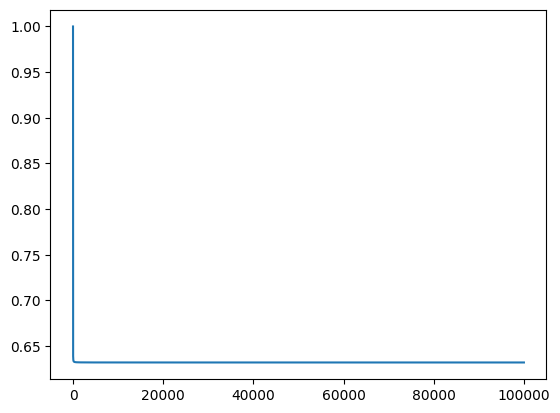

In [21]:
x = np.arange(1, 100001)
y = np.array([p(i) for i in x])
plt.plot(x, y)
plt.show()

#### When n become larger, the probability will converge.

### (h) bootstrap sample probabilities

In [44]:
rng = np.random.default_rng(10)
store = np.empty(10000)
for i in range(10000):
    store[i] = np.sum(rng.choice(100, size=100, replace=True) == 4) > 0
np.mean(store)

0.6362

#### Almost the same as the result in (g)

# Question 5

In [54]:
Default = load_data('Default')
np.random.seed(1)

In [55]:
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [56]:
allvars = Default.columns.drop(['default', 'student'])
design = MS(allvars)
X = design.fit_transform(Default)
y = Default.default == 'Yes'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


In [66]:
Default['default_yes'] = Default['default'].apply(lambda x: 1 if x == 'Yes' else 0)

In [71]:
Default_train, Default_valid = train_test_split(Default, 
                                         test_size= 5000,
                                         random_state=0)

In [73]:
allvars = Default_train.columns.drop(['default', 'student', 'default_yes'])
design = MS(allvars)
X = design.fit_transform(Default_train)
y = Default_train.default_yes
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.389600,0.635000,-17.935,0.000
balance,0.005600,0.000000,16.792,0.000
income,0.000016,0.000007,2.151,0.031


In [87]:
allvars = Default_valid.columns.drop(['default', 'student', 'default_yes'])
design = MS(allvars)
X_valid = design.fit_transform(Default_valid)

In [96]:
probs = results.predict(X_valid)
labels = np.array([0]*X.shape[0])
labels[probs>0.5] = 1
np.mean(labels == Default_valid['default_yes'])

0.971

In [97]:
np.mean(labels != Default_valid['default_yes']) # validation set error

0.029

In [102]:
def validation_split(validation_size):
    Default_train, Default_valid = train_test_split(Default, 
                                         test_size= validation_size,
                                         random_state=0)
    allvars = Default_train.columns.drop(['default', 'student', 'default_yes'])
    design = MS(allvars)
    X = design.fit_transform(Default_train)
    y = Default_train.default_yes
    glm = sm.GLM(y,
                 X,
                 family=sm.families.Binomial())
    results = glm.fit()
    summarize(results)

    allvars = Default_valid.columns.drop(['default', 'student', 'default_yes'])
    design = MS(allvars)
    X_valid = design.fit_transform(Default_valid)

    probs = results.predict(X_valid)
    labels = np.array([0]*X_valid.shape[0])
    labels[probs>0.5] = 1
    print('Validation Set Accuracy:', np.mean(labels == Default_valid['default_yes']))
    print('Validation Set Error:', np.mean(labels != Default_valid['default_yes']))

In [112]:
validation_splits = [1000, 3000, 4000, 5000, 6000, 9000]

In [113]:
for split in validation_splits:
    print('For split: ', split)
    validation_split(split)

For split:  1000
Validation Set Accuracy: 0.97
Validation Set Error: 0.03
For split:  3000
Validation Set Accuracy: 0.9726666666666667
Validation Set Error: 0.027333333333333334
For split:  4000
Validation Set Accuracy: 0.972
Validation Set Error: 0.028
For split:  5000
Validation Set Accuracy: 0.971
Validation Set Error: 0.029
For split:  6000
Validation Set Accuracy: 0.9713333333333334
Validation Set Error: 0.028666666666666667
For split:  9000
Validation Set Accuracy: 0.9728888888888889
Validation Set Error: 0.02711111111111111


In [114]:
Default['student_yes'] = Default['student'].apply(lambda x: 1 if x == 'Yes' else 0)

In [127]:
Default_train, Default_valid = train_test_split(Default, 
                                     test_size= 5000,
                                     random_state=0)
allvars = Default_train.columns.drop(['default', 'student', 'default_yes'])
design = MS(allvars)
X = design.fit_transform(Default_train)
y = Default_train.default_yes
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-10.495500,0.710000,-14.777,0.000
balance,0.005700,0.000000,16.740,0.000
income,-0.000009,0.000012,-0.732,0.464
student_yes,-0.891800,0.344000,-2.591,0.010


In [129]:
allvars = Default_valid.columns.drop(['default', 'student', 'default_yes'])
design = MS(allvars)
X_valid = design.fit_transform(Default_valid)

probs = results.predict(X_valid)
labels = np.array([0]*X_valid.shape[0])
labels[probs>0.5] = 1
print('Validation Set Accuracy:', np.mean(labels == Default_valid['default_yes']))
print('Validation Set Error:', np.mean(labels != Default_valid['default_yes']))

Validation Set Accuracy: 0.9708
Validation Set Error: 0.0292


# Question 6

In [139]:
np.random.seed(0)
Default.head()

,default,student,balance,income,default_yes,student_yes
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [136]:
allvars = Default.columns.drop(['default', 'student', 'student_yes', 'default_yes'])
design = MS(allvars)
X = design.fit_transform(Default)
y = Default.default == 'Yes'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


In [153]:
summarize(results)['coef']

intercept   -11.540500
balance       0.005600
income        0.000021
Name: coef, dtype: float64

In [174]:
summarize(results)['std err']

intercept    0.435000
balance      0.000000
income       0.000005
Name: std err, dtype: float64

In [150]:
def boot_fn(D, idx, param):
    Default = D.loc[idx]
    allvars = Default.columns.drop(['default', 'student', 'student_yes', 'default_yes'])
    design = MS(allvars)
    X = design.fit_transform(Default)
    y = Default.default_yes
    glm = sm.GLM(y,
                 X,
                 family=sm.families.Binomial())
    results = glm.fit()
    std = summarize(results)['std err']
    return std[param]

In [157]:
def boot_coef(D, idx, param):
    Default = D.loc[idx]
    allvars = Default.columns.drop(['default', 'student', 'student_yes', 'default_yes'])
    design = MS(allvars)
    X = design.fit_transform(Default)
    y = Default.default_yes
    glm = sm.GLM(y,
                 X,
                 family=sm.families.Binomial())
    results = glm.fit()
    coef = summarize(results)['coef']
    return coef[param]

In [158]:
boot_fn(Default, np.arange(1000), 'income')

1.52e-05

In [183]:
income_coefficients = [] 
balance_coefficients = []

n = 1000 # number of bootstrapped samples

for _ in range(0,n):
    coef_i = boot_coef(Default, rng.choice(Default.index, 1000), 'income')
    coef_b = boot_coef(Default, rng.choice(Default.index, 1000), 'balance')
    income_coefficients.append(coef_i) 
    balance_coefficients.append(coef_b) 

print('Income:', np.std(income_coefficients))
print('Balance:', np.std(balance_coefficients)) 

Income: 1.6275398698781593e-05
Balance: 0.0007473551699158842


### Similar
##### glm:
1. Income: 4.99e-06
2. Balance: 0.0
##### bootstrap:
1. Income: 1.4e05
2. Balance: ~0

# Question 7

In [185]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [186]:
Weekly['d'] = Weekly['Direction'].apply(lambda x: 1 if x == 'Up' else 0)

In [188]:
allvars = Weekly.columns.drop(['Year', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction', 'd'])
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.d
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


In [197]:
def fit_1(Weekly, idx):
    """
    Train a GLM model on all indices except idx and test on idx.
    """
    # Selecting features and target variable
    features = Weekly.columns.drop(['Year', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction', 'd'])
    X = Weekly[features]
    y = Weekly['d']

    # Splitting data into training and testing sets
    X_train = X.drop(idx)
    X_test = X.loc[idx]
    y_train = y.drop(idx)
    y_test = y.loc[idx]

    # Fit the model
    glm = sm.GLM(y_train, 
                 X_train, 
                 family=sm.families.Binomial())
    results = glm.fit()

    # Make predictions
    prediction = results.predict(X_test) > 0.5  # Reshape for single sample

    # Comparing prediction to actual value
    return (prediction.values[0] == y_test)

In [201]:
fit_1(Weekly, 0)

False

In [202]:
predictions = []
for idx in Weekly.index:
    predictions.append(fit_1(Weekly, idx))

In [204]:
sum(predictions) / len(predictions)

0.5353535353535354

In [208]:
1 - np.mean(predictions)

0.46464646464646464

# Question 8

In [241]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100) # X - 2X^2 + epsilon

##### n = 100, p = 2

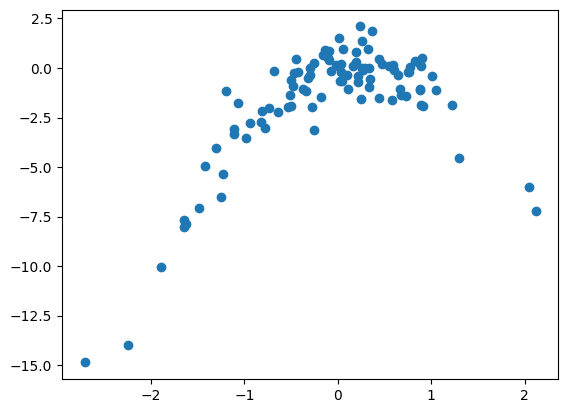

In [242]:
plt.scatter(x, y)
plt.show()

In [243]:
df = pd.DataFrame({'X': x, 'y': y})
hp_model = sklearn_sm(sm.OLS,
                      MS(['X']))
X = df[['X']]
y = df['y']
cv_results = cross_validate(hp_model,
                            X,
                            y,
                            cv=100)
cv_err = np.mean(cv_results['test_score'])
round(cv_err, 4)

6.633

In [244]:
cv_error = np.zeros(4)
H = np.array(df['X'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1, 5)): # [1, 5)
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=100)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

##### New Random Range

In [246]:
rng = np.random.default_rng(42)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100) # X - 2X^2 + epsilon

df = pd.DataFrame({'X': x, 'y': y})
cv_error = np.zeros(4)
H = np.array(df['X'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1, 5)): # [1, 5)
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=100)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([4.25188287, 0.96399846, 0.99127119, 1.0181801 ])

#### Model with X^2 is better.

In [262]:
rng = np.random.default_rng(42)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100) # X - 2X^2 + epsilon

df = pd.DataFrame({'X': x, 'y': y})
H = np.array(df['X'])
X = np.power.outer(H, np.arange(3))
df_new = pd.DataFrame({'intercept': X[:, 0],
                       'x': X[:, 1],
                       'x_sqr': X[:, 2],
                       'y': y})

In [264]:
X = df_new[['intercept', 'x', 'x_sqr']]
y = df_new['y']
model = sm.OLS(y, X)
results = model.fit()

In [265]:
summarize(results)

,coef,std err,t,P>|t|
intercept,0.1072,0.122,0.878,0.382
x,1.0800,0.129,8.400,0.000
x_sqr,-2.1898,0.125,-17.576,0.000


##### This fits with our LOOCV Hypothesis

# Question 9

In [266]:
Boston = load_data('Boston')

In [268]:
mu = Boston['medv'].mean()
mu

22.532806324110677

In [276]:
std = Boston['medv'].std() / math.sqrt(Boston.shape[0])
std

0.40886114749753505

In [299]:
def boot_fn_mean(D, idx):
    return D['medv'].loc[idx].mean()

bootstrap_means = []
n = 1000
for _ in range(n):
    bootstrap_means.append(boot_fn_mean(Boston, rng.choice(Boston.index, Boston.shape[0], replace=True)))

SE = np.std(bootstrap_means)
SE

0.40489134448142533

In [300]:
print(mu - 2*SE, mu + 2*SE)

21.723023635147825 23.34258901307353


In [301]:
medv = Boston.medv
medv.median()

21.2

In [302]:
def boot_fn_med(D, idx):
    return D['medv'].loc[idx].median()

bootstrap_medians = []
n = 1000
for _ in range(n):
    bootstrap_medians.append(boot_fn_med(Boston, rng.choice(Boston.index, Boston.shape[0], replace=True)))
SE = np.std(bootstrap_medians)
SE

0.3702979847366169

In [312]:
mu_0_1 = np.percentile(Boston['medv'], 10)
mu_0_1

12.75

In [315]:
def boot_fn_perc(D, idx):
    return D['medv'].loc[idx].quantile(0.1)

bootstrap_percs = []
n = 1000
for _ in range(n):
    bootstrap_percs.append(boot_fn_perc(Boston, rng.choice(Boston.index, Boston.shape[0], replace=True)))

SE = np.std(bootstrap_percs)
SE

0.5046672071771654